In [2]:
from HighContrastPointDetector import HighContrastPointDetector
from FingerprintComparator import FingerPrintComparator
from ClusterCreator import ClusterCreator
from Fingerprint import Fingerprint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os

In [2]:
db_root = "fingerprintsDatabase"

def is_for_db(image_name):
    return image_name[8] == "f"

def concatenate(*relative_paths):
    return "/".join(relative_paths)

db_images_paths, sample_images_path = [], []
for directory in os.listdir(db_root):
    for image in os.listdir(concatenate(db_root, directory)):
        if is_for_db(image): db_images_paths.append(concatenate(db_root, directory, image))
        else: sample_images_path.append(concatenate(db_root, directory, image))

In [3]:
def load_fingerprints(paths):
    return [Fingerprint(path.split("/")[-1].split(".")[0], cv2.imread(path)) for path in paths]

db_fingerprints = load_fingerprints(db_images_paths)
sample_fingerprints = load_fingerprints(sample_images_path)

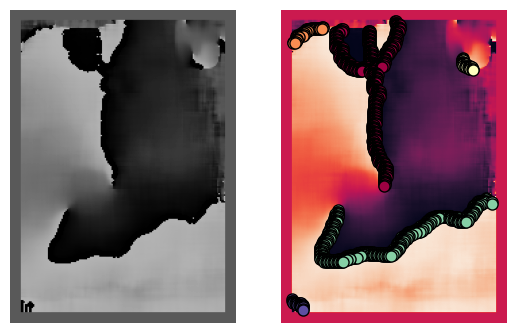

In [38]:
def create_image_with_hc(image):
    result = image.copy()
    for point in HighContrastPointDetector(3.7).calculate_for(image):
        cv2.circle(result, (point[1], point[0]), 1, (0, 255, 0), -1)
    return result

def show_cluster(image, clusters):
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(create_image_with_hc(image), cmap='gray', vmin=0, vmax=255)
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(image)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(clusters))]
    for label, (color, points) in enumerate(zip(colors, clusters.values())):
        cluster_points = np.array(points)
        plt.plot(cluster_points[:, 1], cluster_points[:, 0], 'o', markerfacecolor=tuple(color), markeredgecolor="k",
                 markersize=8)

index = 4

image = sample_fingerprints[index].orientation_field
hc_points = HighContrastPointDetector(3).calculate_for(image)
dictionary = ClusterCreator(distance=5, minimum_samples_per_cluster=20).calculate(hc_points)
show_cluster(image, dictionary)

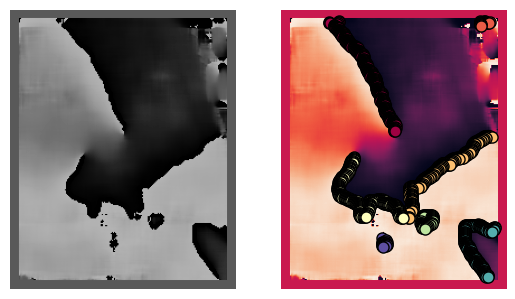

In [39]:
image = db_fingerprints[index].orientation_field
hc_points = HighContrastPointDetector(3.5).calculate_for(image)
dictionary = ClusterCreator(distance=5, minimum_samples_per_cluster=20).calculate(hc_points)
show_cluster(image, dictionary)

In [6]:
comparator = FingerPrintComparator(db_fingerprints)
result = {}
for fingerprint in sample_fingerprints:
    distances = [dto.distance for dto in comparator.fingerprint_similar_to(fingerprint)]
    probabilities_list = np.array(distances) / sum(distances)
    result[fingerprint.name] = probabilities_list

In [7]:
confusion_matrix = np.zeros((len(result), len(result)))
for index, key in enumerate(result.keys()):
    confusion_matrix[index,:] = result[key]

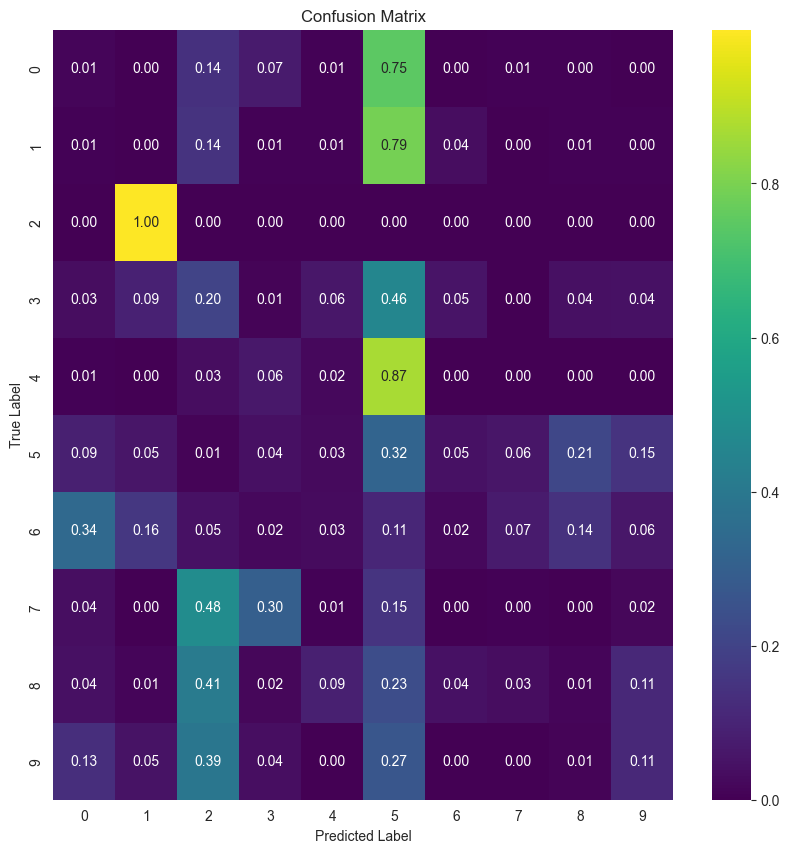

In [8]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, cmap="viridis", fmt=".2f")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [9]:
well_classified = []
for index, key in enumerate(result):
    well_classified.append(result[key][index])

not_classified = []
for index, key in enumerate(result):
    not_classified += list(result[key][0:index]) + list(result[key][index+1:])


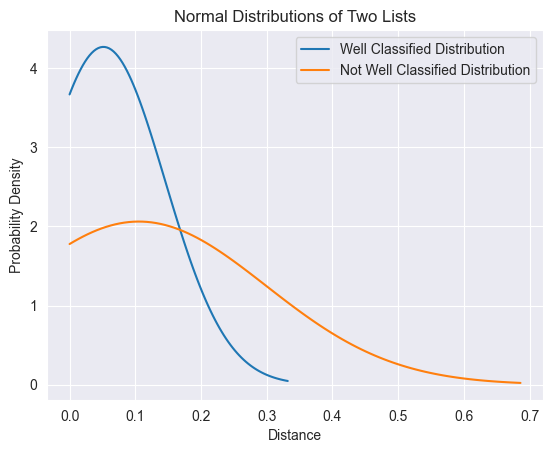

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


def plot_normal_distributions(well_classified_list, not_classified_list):
    mean1, std1 = np.mean(well_classified_list), np.std(well_classified_list)
    mean2, std2 = np.mean(not_classified_list), np.std(not_classified_list)
    x1 = np.linspace(0, mean1 + 3 * std1, 100)
    x2 = np.linspace(0, mean2 + 3 * std2, 100)
    plt.plot(x1, norm.pdf(x1, mean1, std1), label='Well Classified Distribution')
    plt.plot(x2, norm.pdf(x2, mean2, std2), label='Not Well Classified Distribution')
    plt.title('Normal Distributions of Two Lists')
    plt.xlabel('Distance')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

plot_normal_distributions(well_classified, not_classified)


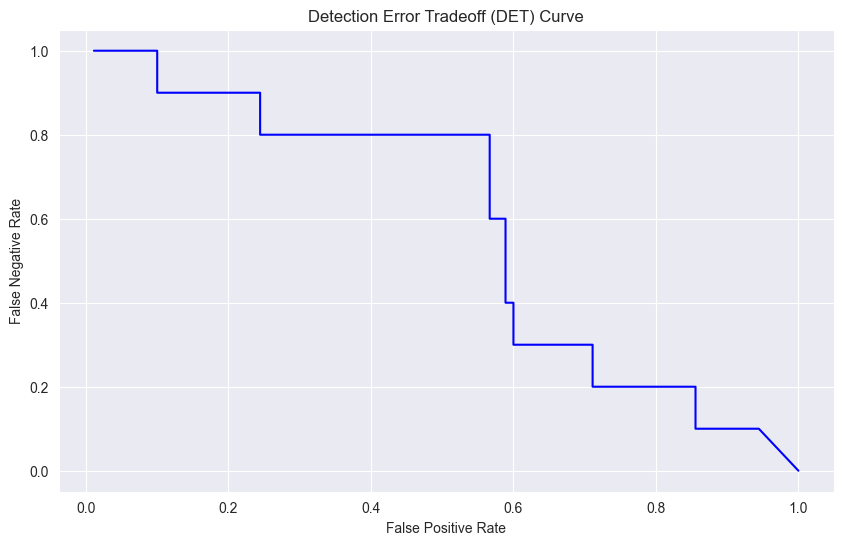

In [37]:
from sklearn.metrics import det_curve

labels = [1] * len(well_classified) + [0] * len(not_classified)

# Combining the scores into a single list
scores = well_classified + not_classified

# Calculating the false positive and false negative rates
fpr, fnr, thresholds = det_curve(labels, scores)

# Plotting the DET curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, fnr, color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
plt.title('Detection Error Tradeoff (DET) Curve')
plt.grid(True)
plt.show()